# 数据读取
读取csv数据，初次得到的数据结构如下：
```
data=
[
    {
        'date',
        'time',
        'data':[
            第road_id行，存放road_id的数据：[status,speed]
        ]
        不同时间的不同data不等长
    }
]
```

In [80]:
import csv
import os
file_path='data'
file_list=sorted(os.listdir(file_path))
date_time={}
for fname in file_list:
    if fname[0]=='.':
        continue
        
    date=fname[8:13]
    time=fname[14:22]
    
    if date>='10-02' and date<='10-15':
        if date not in date_time:
            date_time[date]=[time]
        else:
            date_time[date].append(time)
#把每一天的时间段数据归一化，抛弃尾端数据
min_time_num=216
for date,times in date_time.items():
    if len(times)<min_time_num:
        min_time_num=len(times)
for date in date_time:
    if len(date_time[date])>min_time_num:
        date_time[date]=date_time[date][0:min_time_num]

road_dist={}
data=[]

for date,times in date_time.items():
    for time in times:
        fname='ts_2021-'+date+' '+time+'.csv'
        date_data=[[0,0] for i in range(len(road_dist))]
        with open(file_path+'/'+fname,'r') as f:
            csv_reader = csv.reader(f)
            for row in csv_reader:
                if row[0] in road_dist:
                    if int(row[1])>date_data[road_dist[row[0]]][0]:
                        date_data[road_dist[row[0]]][0]=int(row[1])
                        date_data[road_dist[row[0]]][1]=int(row[4])
                else:
                    road_dist[row[0]]=len(road_dist)
                    date_data.append([int(row[1]),int(row[4])])
            f.close()
        #time=(int(fname[14:16])-5)*60+int(fname[17:19])
        data.append({'date':date,'time':time,'data':date_data})

# 数据清洗
二次处理读到的csv数据，使其转化为光栅(Raster)数据
```
dataset=[
    for each day
    [
        for each roads
        [
            for each time
            [
                [status,speed]
            ]
        ]
    ]
]
```
记每天为一个样本组，天数=样本数=N，每个样本记录了E个道路信息，每个道路包含T个时间片的监测数据，每个数据有C个特征

In [81]:
import numpy as np
from collections import Counter
dataset=[]
raster=[[] for i in range(len(road_dist))]
for index,item in enumerate(data):
    for road in road_dist:
        road_id=road_dist[(road)]
        if road_id<len(item['data']):
            raster[road_id].append(item['data'][road_id])
        else:
            raster[road_id].append([0,0])

    if index==len(data)-1 or item['date']!=data[index+1]['date']:
        dataset.append(raster)
        raster=[[] for i in range(len(road_dist))]

dataset=np.array(dataset)

将每一天的数据拼接
```
dataset=[
    for each roads
    [
        for all time
        [
            [status,speed]
        ]
    ]
]
```
样本记录了E个道路信息，每个道路包含N*T个时间片的监测数据，每个数据有C个特征

In [82]:
dataset=np.concatenate(dataset,axis=1)

将数据缺失率在5%以上的路段剔除

In [85]:
road_zip=dict(zip(road_dist.keys(), dataset))

delete_roads=[]
for road,data in road_zip.items():
    null_cnt=0
    zero_cnt=Counter(data[:,0])[0]
    if zero_cnt>len(data)*0.05:
        delete_roads.append(road)
for road in delete_roads:
    road_zip.pop(road)

绘制光栅图

In [86]:
#print(road_dist)
import cv2 as cv
sample=np.array(list(road_zip.values()))
print(sample.shape)
image=85*sample[:,:,0]

cv.imwrite("filename.png", image)

(717, 3010, 2)


True

# 模式挖掘统计
## 统计拥堵发生的时间特征

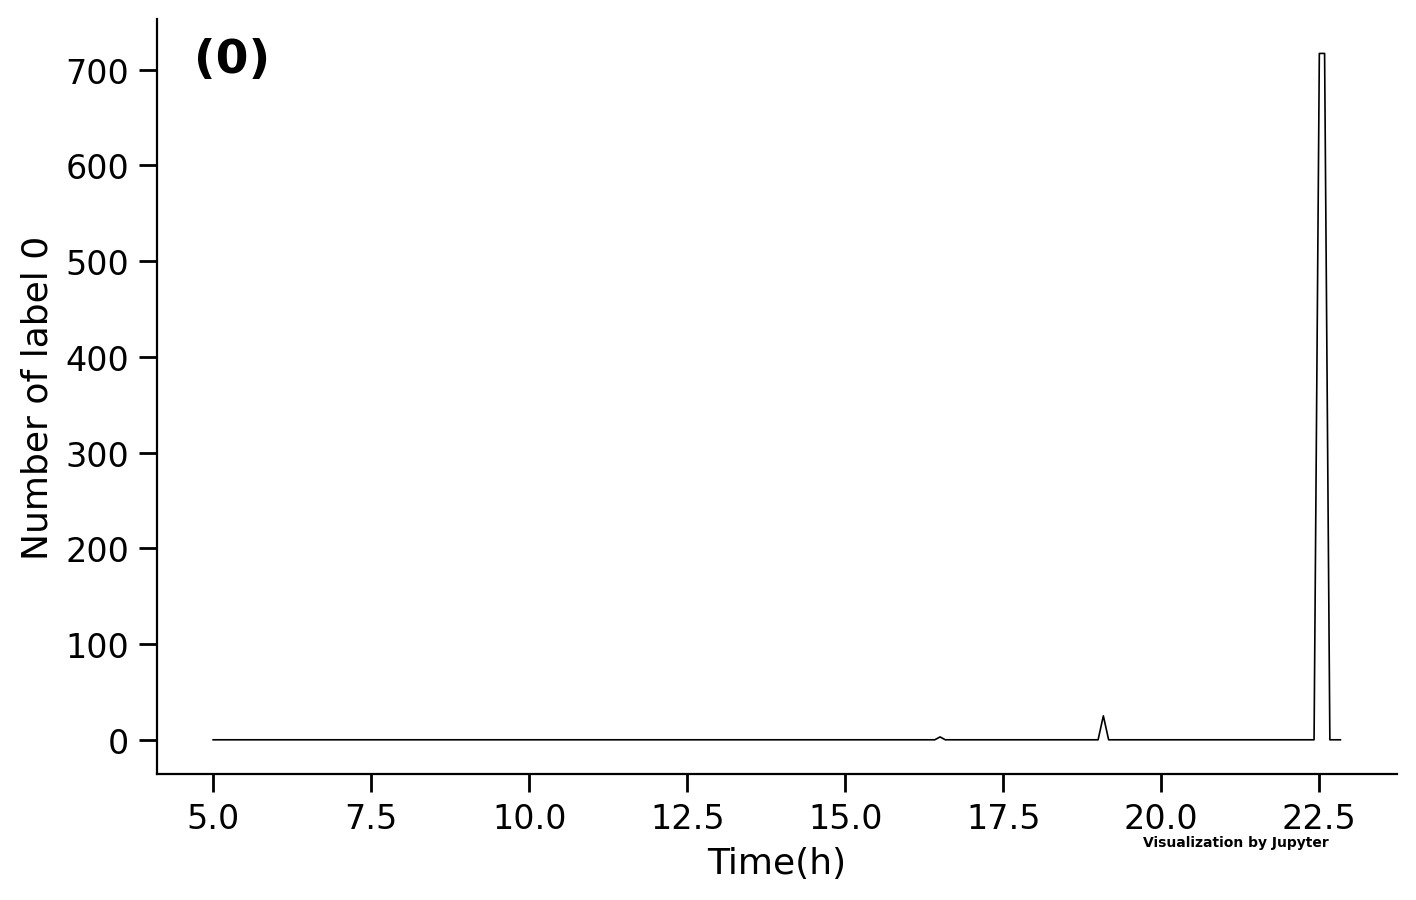

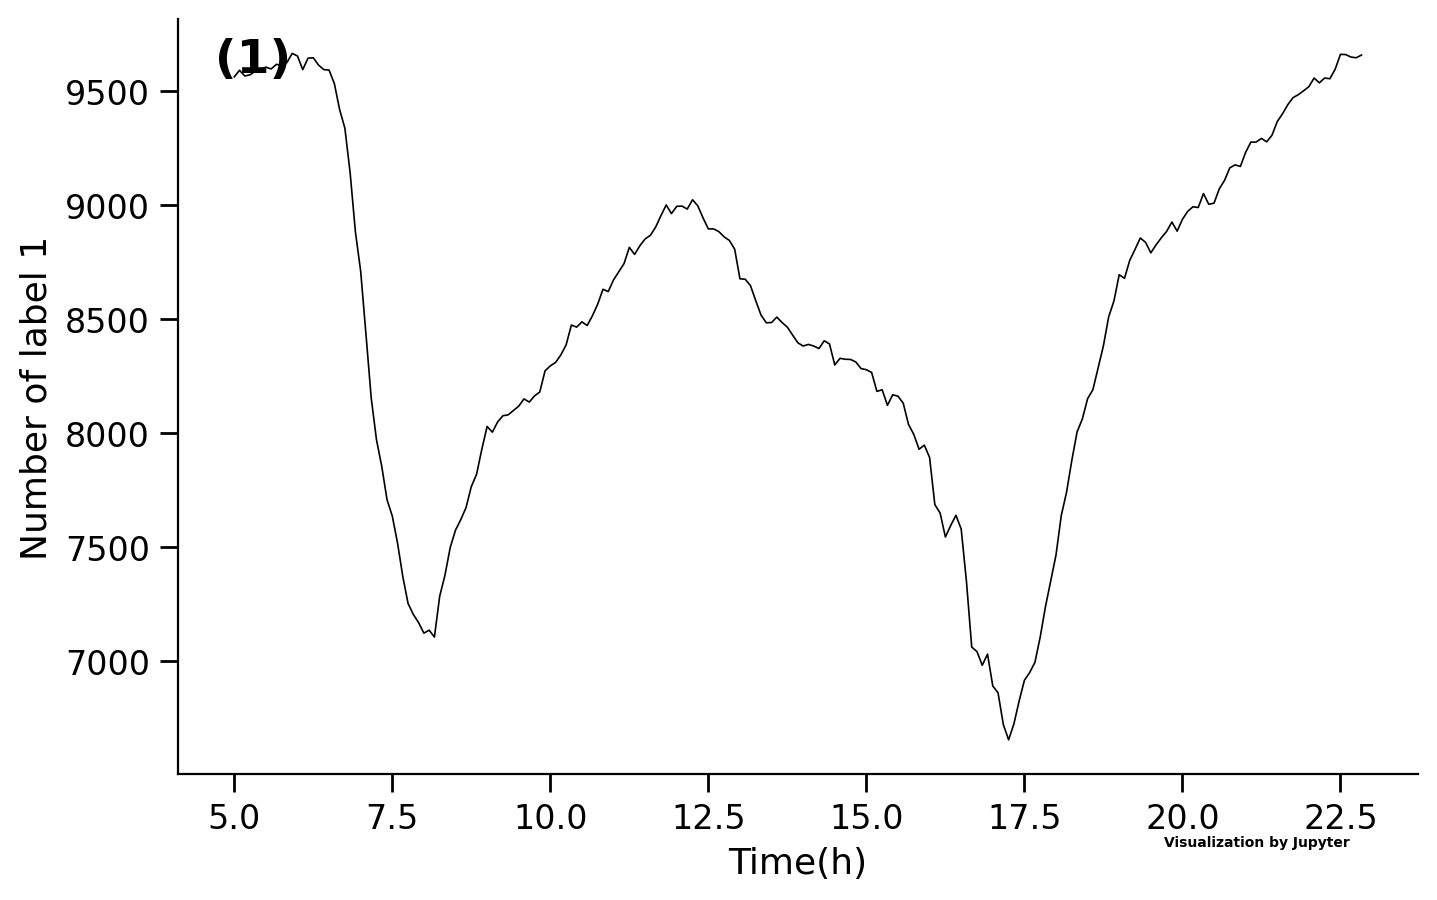

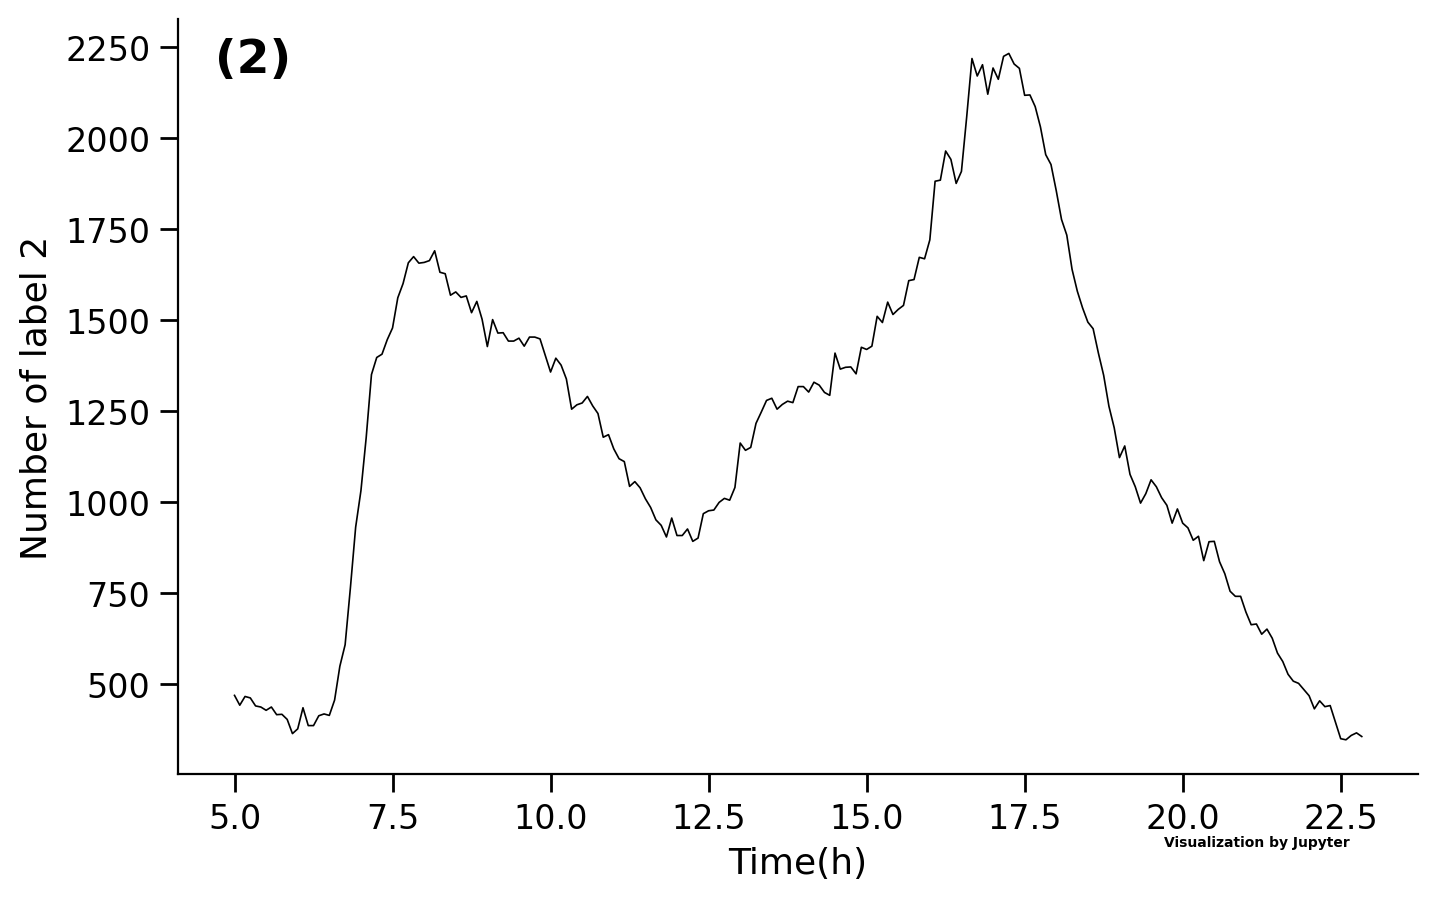

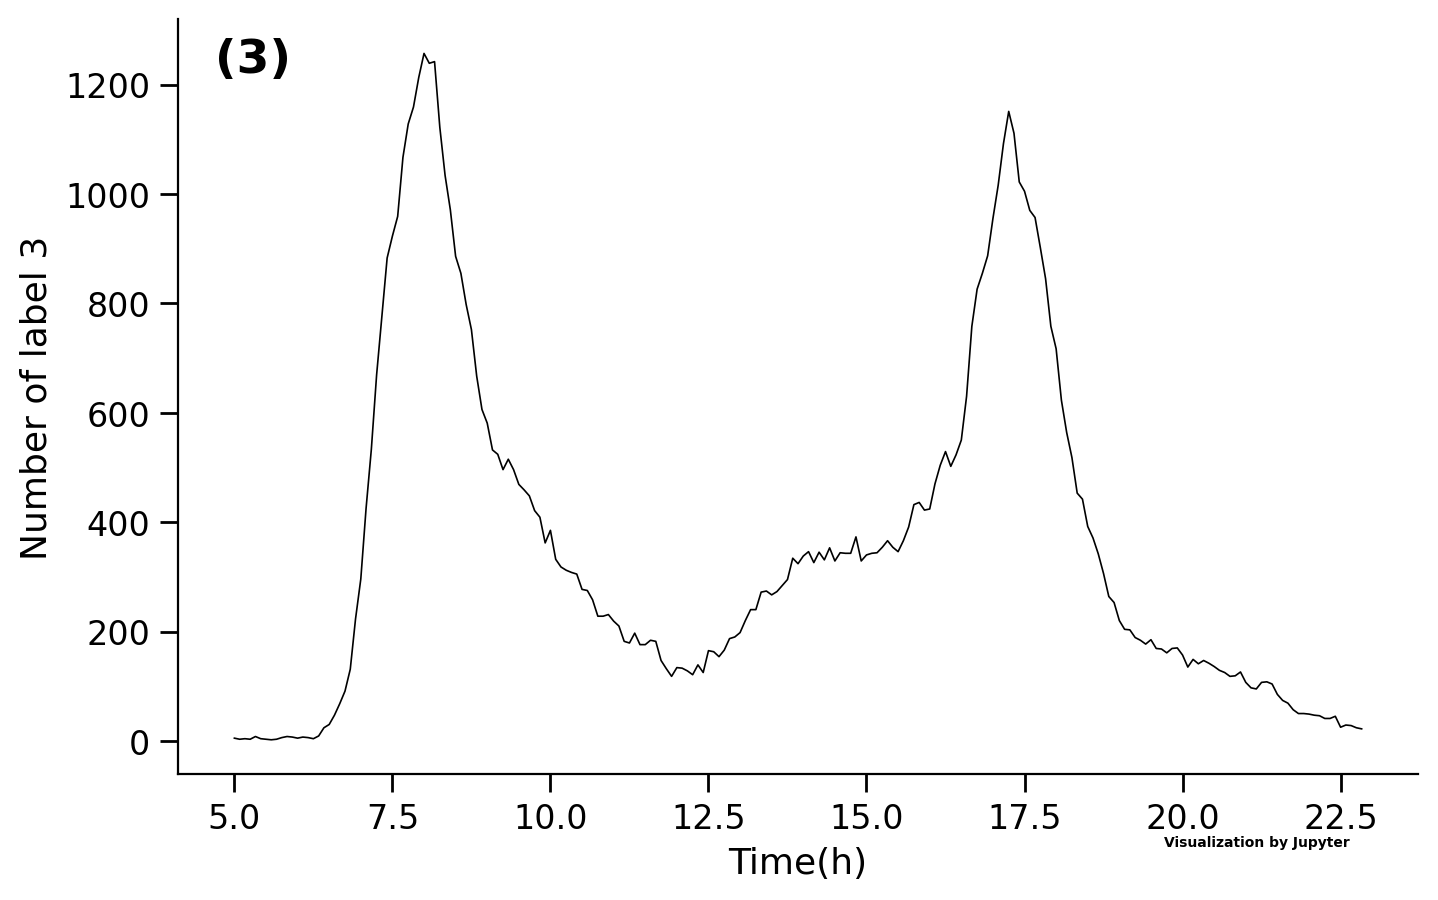

In [95]:
import matplotlib.pyplot as plt
data=np.array(list(road_zip.values()))[:,:,0]
data=data.reshape(-1,min_time_num)
data=data.T
result={0:[],1:[],2:[],3:[]}
for index,time_data in enumerate(data):
    cnt=Counter(time_data)
    for i in result:
        if i in cnt:
            result[i].append(cnt[i])
        else:
            result[i].append(0)
#把缺失值算作1（畅通）
result[1]=list(np.array(result[0])+np.array(result[1]))
label = [(i*5)/60+5 for i in range(len(result[0]))]
for index,value in result.items():
    fig,ax = plt.subplots(figsize=(8,5),dpi=200)
    ax.plot(label, value, color='black', linewidth=.6)
    ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel(f'Number of label {index}',fontsize=13)
    ax.set_xlabel('Time(h)',fontsize=13)
    text_font = {'size':'17','weight':'bold','color':'black'}
    ax.text(.03,.93,f'({index})',transform = ax.transAxes,fontdict=text_font,zorder=4)
    ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
    fig.show()


## 统计拥堵发生的持续时间


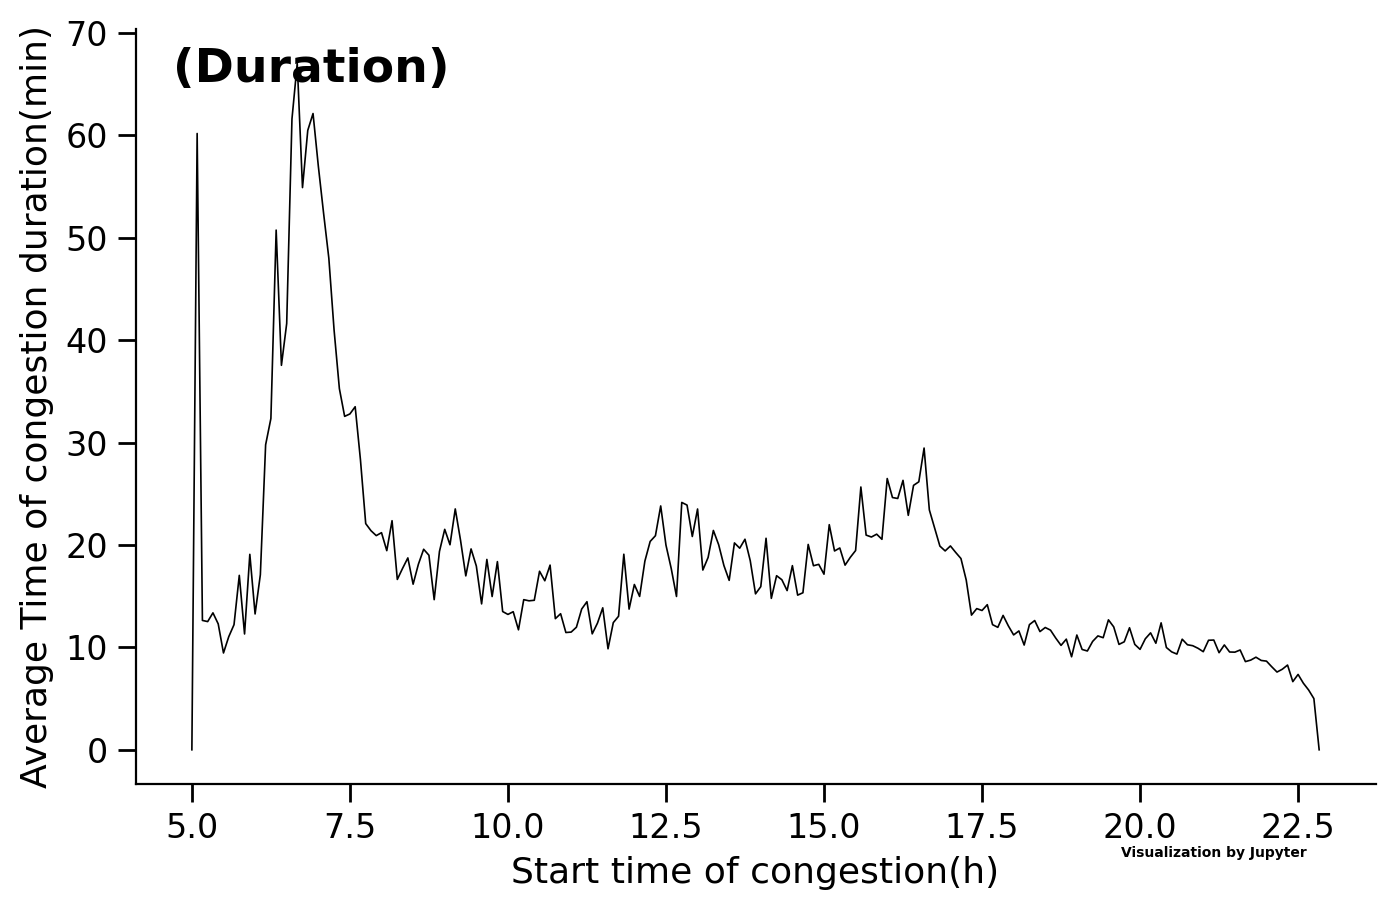

In [96]:
import matplotlib.pyplot as plt
data=np.array(list(road_zip.values()))[:,:,0]
data=data.reshape(data.shape[0],-1,min_time_num)

result=[]
for road in data:
    for date in road:
        start_time=0
        duration=0
        for index,item in enumerate(date):
            if start_time==0 and item>1:
                start_time=index
            if start_time!=0 and item<=1:
                duration=index-start_time
                #如果是range(1)则代表计算拥堵开始时刻的拥堵时间
                #如果是range(duration)则代表计算发生拥堵后每个时刻的拥堵时间
                for i in range(1):
                    result.append({'start_time':start_time+i,'duration':duration-i})
                start_time=0
                duration=0             
statistic={}
for item in result:
    if item['start_time'] in statistic:
        statistic[item['start_time']].append(item['duration'])
    else:
        statistic[item['start_time']]=[item['duration']]
avg_statistic=[]
for time_slice in range(min_time_num):
    if time_slice in statistic:
        avg_statistic.append(np.array(statistic[time_slice]).mean()*5)
    else:
        avg_statistic.append(0)

label = [(i*5)/60+5 for i in range(len(avg_statistic))]
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
ax.plot(label, avg_statistic, color='black', linewidth=.6)
ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Average Time of congestion duration(min)',fontsize=13)
ax.set_xlabel('Start time of congestion(h)',fontsize=13)
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.03,.93,'(Duration)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
fig.show()
    